epoch: 0
Train Loss: 0.6873, Train_Acc: 0.5742
Test Loss: 0.7070, Test_Acc: 0.3400
epoch: 50
Train Loss: 0.6333, Train_Acc: 0.6411
Test Loss: 0.6742, Test_Acc: 0.5600
epoch: 100
Train Loss: 0.6111, Train_Acc: 0.7081
Test Loss: 0.6633, Test_Acc: 0.6000
epoch: 150
Train Loss: 0.6081, Train_Acc: 0.7273
Test Loss: 0.6400, Test_Acc: 0.6400
epoch: 200
Train Loss: 0.6004, Train_Acc: 0.7225
Test Loss: 0.6426, Test_Acc: 0.6000
epoch: 250
Train Loss: 0.5972, Train_Acc: 0.6938
Test Loss: 0.6377, Test_Acc: 0.6400
epoch: 300
Train Loss: 0.5882, Train_Acc: 0.6986
Test Loss: 0.6305, Test_Acc: 0.6800
epoch: 350
Train Loss: 0.591, Train_Acc: 0.7416
Test Loss: 0.6242, Test_Acc: 0.6800
epoch: 400
Train Loss: 0.5907, Train_Acc: 0.7177
Test Loss: 0.6254, Test_Acc: 0.6800
epoch: 450
Train Loss: 0.576, Train_Acc: 0.7225
Test Loss: 0.6177, Test_Acc: 0.6800
epoch: 500
Train Loss: 0.5715, Train_Acc: 0.7416
Test Loss: 0.6237, Test_Acc: 0.6800
epoch: 550
Train Loss: 0.5829, Train_Acc: 0.7129
Test Loss: 0.6223, Te

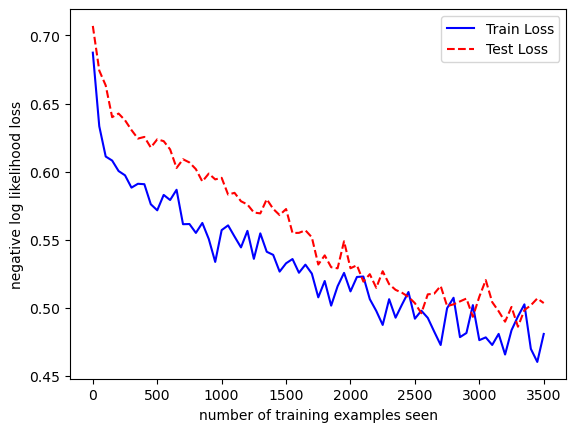

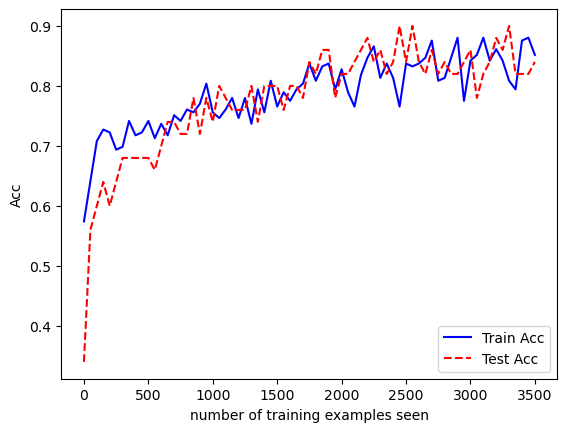

In [1]:
import numpy as np
import h5py as h5
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

batch_size_train = 209
batch_size_test = 50
learning_rate = 0.0075
num_epoches = 3500
momentum = 0.5


train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(48),
    transforms.RandomHorizontalFlip(),
    
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


test_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(48), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class MyDataset(Dataset):
    
    def __init__(self, archive,image,label,transform = None):

        self.archive = h5.File(archive, 'r')
        self.images = self.archive[image]
        self.labels = self.archive[label]
        self.transform = transform
    
    def __getitem__(self,index):
        
        
        image = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)  
        return image ,label
    
    def __len__(self):
        return len(self.labels)
        
train_dataset = MyDataset('/home/tian/dataset/catvnocat/train/train_catvnoncat.h5','train_set_x','train_set_y',train_transformer)
test_dataset = MyDataset('/home/tian/dataset/catvnocat/test/test_catvnoncat.h5','test_set_x','test_set_y',test_transformer)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)



class Batch_Net(nn.Module):
    
    def __init__(self, in_dim, n_hidden_1,n_hidden_2,out_dim):
        super(Batch_Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1), nn.ReLU(True),nn.Dropout(0.25))#,nn.Dropout(0.3))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2), nn.ReLU(True),nn.Dropout(0.25))#,nn.Dropout(0.5))#,nn.Dropout(0.3))#,nn.Dropout(0.5))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim),nn.Softmax(dim = 1))
     
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

#构建模型实例 
model = Batch_Net(48*48*3,90,10,2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay= 1e-4)



train_losses = []
train_acc = []
train_counter = [i * len(train_loader)*50 for i in range(num_epoches // 50 + 1)]
test_losses = []
test_acc = []
test_counter = [i * len(test_loader)*50 for i in range(num_epoches // 50 + 1)]


for epoch in range(num_epoches+1):
    model.train()
    
    for data in train_loader:
        img, label = data
        img = img.view(img.size(0), -1)  
        img = Variable(img)
        label = Variable(label)
        out = model(img.to(torch.float32))
        loss = criterion(out, label)
        _, pred = torch.max(out, 1)
        acc = (pred == label).sum().item() / (len(train_dataset))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    eval_loss = 0
    eval_acc = 0
        
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        out = model(img.to(torch.float32))
        loss_1 = criterion(out, label)
        eval_loss += loss_1.data.item()*label.size(0)
        _, pred = torch.max(out, 1)
        eval_acc += (pred == label).sum().item() / len(test_dataset)

    if epoch%50 == 0:
        train_losses.append(loss.data.item())
        train_acc.append(acc)
        test_losses.append(loss_1.data.item())
        test_acc.append(eval_acc)

        print('epoch: {}'.format(epoch))
        print('Train Loss: {:.4}, Train_Acc: {:.4}'.format(loss.data.item(), acc))
        print('Test Loss: {:.4f}, Test_Acc: {:.4f}'.format(eval_loss / (len(test_dataset)),eval_acc))


fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, '--',color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

fig = plt.figure()
plt.plot(train_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, '--',color='red')
plt.legend(['Train Acc', 'Test Acc'], loc='lower right')
plt.xlabel('number of training examples seen')
plt.ylabel('Acc')

plt.show()